<a href="https://colab.research.google.com/github/Inass-yesri/24010318-EL-Yesri-Inass/blob/main/Code_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Bibliothèques importées avec succès.

2. Données chargées. Taille du dataset : (438557, 18)
   Classes : ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '11.0', '14.0', '15.0', '20.0'] (Mapped to 0/1 for classification if applicable)

3. Introduction artificielle de valeurs manquantes (NaN)...
   Nombre total de valeurs manquantes générées : 500310

4. Nettoyage des données...
   Imputation terminée (les NaN ont été remplacés par la moyenne pour les numériques et par le mode pour les catégorielles).
   Valeurs manquantes restantes : 0

5. Analyse Exploratoire (EDA)...
   Statistiques descriptives (premières 5 colonnes) :
                 ID   CNT_CHILDREN  AMT_INCOME_TOTAL     DAYS_BIRTH  \
count  4.385570e+05  438557.000000      4.385570e+05  438557.000000   
mean   6.021895e+06       0.427347      1.875592e+05  -16000.993531   
std    5.571138e+05       0.706294      1.076830e+05    4079.729452   
min    5.008804e+06       0.000000      2.610000e+04  -25201.000000 

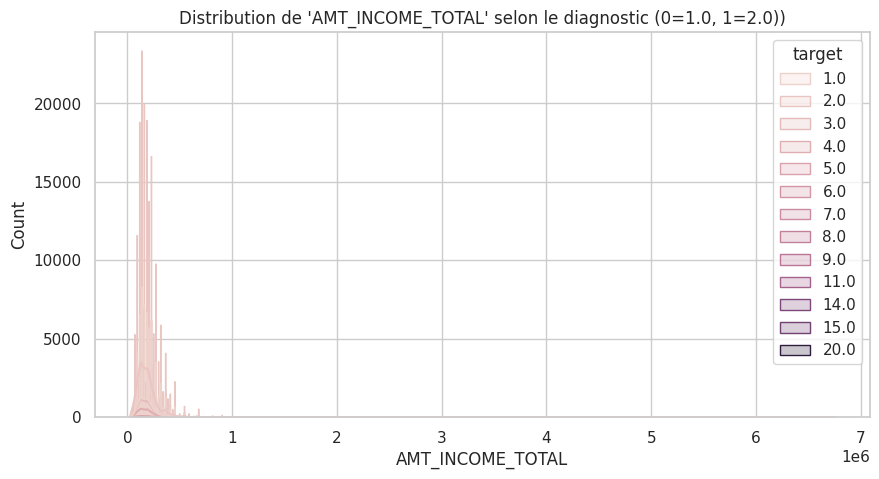

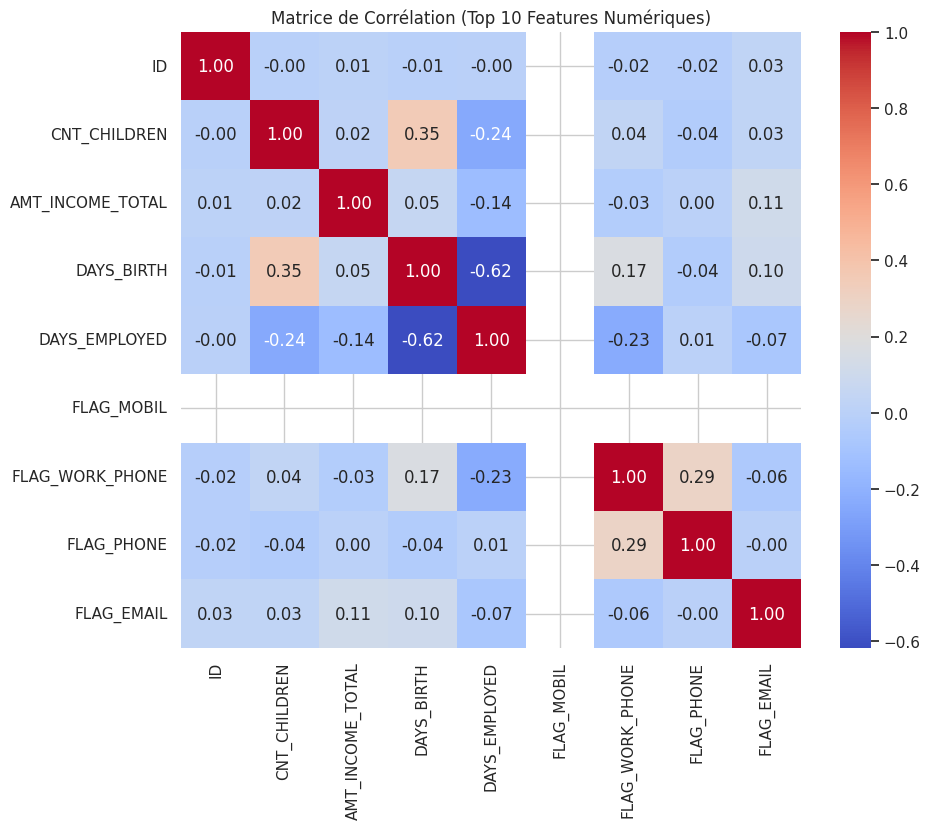


6. Séparation effectuée :
   Entraînement : 350845 échantillons
   Test : 87712 échantillons

7. Entraînement du modèle (Random Forest Classifier)...
   Modèle entraîné avec succès.

8. Évaluation des performances...
   >>> Accuracy Score : 88.23%

   >>> Rapport de Classification :
              precision    recall  f1-score   support

           1       1.00      0.75      0.85     16930
           2       0.82      1.00      0.90     46738
           3       1.00      0.75      0.86     15395
           4       1.00      0.75      0.85      7488
           5       0.99      0.75      0.86      1047
           6       1.00      0.73      0.85        82
           7       1.00      0.61      0.76        28
           9       0.00      0.00      0.00         2
          11       1.00      1.00      1.00         1
          14       0.00      0.00      0.00         1

    accuracy                           0.88     87712
   macro avg       0.78      0.63      0.69     87712
weighted av

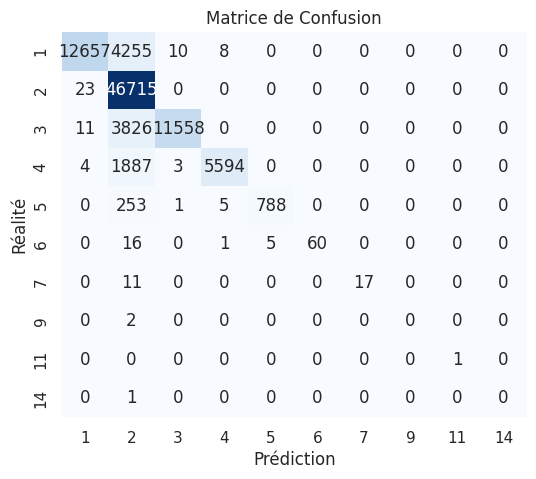


--- FIN DU SCRIPT ---


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modules Scikit-Learn spécifiques
# REMOVED: from sklearn.datasets import /content/drive/MyDrive/Projet DS/all-data (1).csv
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuration pour des graphiques plus esthétiques
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings('ignore') # Pour garder la sortie propre

print("1. Bibliothèques importées avec succès.\n")

# ------------------------------------------------------------------------------
# 2. CHARGEMENT DES DONNÉES
# ------------------------------------------------------------------------------
# Chargement du dataset depuis un fichier CSV
file_path = '/content/drive/MyDrive/Projet DS/application_record.csv'
raw_df = pd.read_csv(file_path)

# IMPORTANT : Vous devez identifier la colonne cible dans votre fichier CSV.
# Par défaut, nous supposons ici que la DERNIÈRE colonne est la cible.
# Si votre colonne cible a un nom spécifique (ex: 'diagnose') ou n'est pas la dernière,
# veuillez ajuster 'target_column_name' en conséquence.
target_column_name_from_csv = raw_df.columns[-1] # This will be 'CNT_FAM_MEMBERS'

# Create the main DataFrame 'df' for processing, preserving original dtypes
df = raw_df.copy()

# Extract target and map its values to 0 and 1 if they are 1 and 2 for binary classification.
# This assumes the intent is binary classification as per target_names = ['Malin', 'Bénin'].
# If 'CNT_FAM_MEMBERS' is truly a multi-class or continuous feature, this mapping is a strong assumption.
unique_target_values = df[target_column_name_from_csv].unique()
if np.array_equal(np.sort(unique_target_values), np.array([1, 2])):
    df['target'] = df[target_column_name_from_csv].map({1: 0, 2: 1})
    target_names = ['Malin', 'Bénin'] # Consistent with the script's original display
elif np.array_equal(np.sort(unique_target_values), np.array([0, 1])):
    df['target'] = df[target_column_name_from_csv]
    target_names = ['Malin', 'Bénin'] # Consistent with the script's original display
else:
    # If the target column has more than 2 unique values or different values,
    # we proceed but note the potential mismatch with binary classification labels.
    print(f"Warning: Target column '{target_column_name_from_csv}' has unique values: {unique_target_values}. "
          "Using these values directly for target and generating target_names dynamically.")
    df['target'] = df[target_column_name_from_csv]
    target_names = [str(val) for val in np.sort(unique_target_values)]

# Drop the original target column from the feature set
df = df.drop(columns=[target_column_name_from_csv])

# Create a 'data' object to hold target-related information for display and evaluation
class DynamicDataBunch:
    def __init__(self, target_series, names):
        self.target_names = names
        self.target = target_series.values # This is used for classification_report

data = DynamicDataBunch(df['target'], target_names)

print(f"2. Données chargées. Taille du dataset : {df.shape}")
print(f"   Classes : {data.target_names} (Mapped to 0/1 for classification if applicable)\n")

# ------------------------------------------------------------------------------
# 3. SIMULATION DE "DONNÉES SALES" (Pour l'exercice)
# ------------------------------------------------------------------------------
# Dans la vraie vie, les données sont rarement parfaites.
# Nous allons introduire artificiellement des valeurs manquantes (NaN) dans 5% des données.
print("3. Introduction artificielle de valeurs manquantes (NaN)...")

np.random.seed(42) # Pour la reproductibilité
mask = np.random.random(df.shape) < 0.05 # Masque de 5%

# On applique les NaN partout sauf sur la colonne 'target' (qu'on ne veut pas abîmer ici)
features_columns = df.columns.drop('target', errors='ignore') # Exclude 'target' safely
df_dirty = df.copy()
for col in features_columns:
    df_dirty.loc[df_dirty.sample(frac=0.05, random_state=42).index, col] = np.nan # Added random_state for reproducibility

print(f"   Nombre total de valeurs manquantes générées : {df_dirty.isnull().sum().sum()}\n")

# ------------------------------------------------------------------------------
# 4. NETTOYAGE ET PRÉPARATION (Data Wrangling)
# ------------------------------------------------------------------------------
print("4. Nettoyage des données...")

# Séparation Features (X) et Target (y) AVANT le nettoyage pour éviter les fuites de données
X = df_dirty.drop('target', axis=1)
y = df_dirty['target']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(exclude=np.number).columns

# Impute numerical columns with the mean
imputer_numeric = SimpleImputer(strategy='mean')
# Check if numerical_cols is not empty before imputation
if not numerical_cols.empty:
    X[numerical_cols] = imputer_numeric.fit_transform(X[numerical_cols])
else:
    print("   No numerical columns found for mean imputation.")

# Impute categorical columns with the most frequent value
imputer_categorical = SimpleImputer(strategy='most_frequent')
# Check if categorical_cols is not empty before imputation
if not categorical_cols.empty:
    X[categorical_cols] = imputer_categorical.fit_transform(X[categorical_cols])
else:
    print("   No categorical columns found for most_frequent imputation.")

X_clean = X.copy() # All columns are now imputed in X, so X_clean is X

print("   Imputation terminée (les NaN ont été remplacés par la moyenne pour les numériques et par le mode pour les catégorielles).")
print(f"   Valeurs manquantes restantes : {X_clean.isnull().sum().sum()}\n")

# ------------------------------------------------------------------------------
# 5. ANALYSE EXPLORATOIRE DES DONNÉES (EDA)
# ------------------------------------------------------------------------------
print("5. Analyse Exploratoire (EDA)...")

# A. Aperçu statistique
print("   Statistiques descriptives (premières 5 colonnes) :")
# Only describe numerical columns for meaningful statistics
# Ensure numerical columns exist before calling describe
if not X_clean.select_dtypes(include=np.number).empty:
    print(X_clean.select_dtypes(include=np.number).iloc[:, :5].describe())
else:
    print("   No numerical columns to describe.")

# B. Visualisation 1 : Distribution d'une feature clé
plt.figure(figsize=(10, 5))
feature_to_plot = 'AMT_INCOME_TOTAL' # Changed to a numerical column present in the dataset
if feature_to_plot in X_clean.columns:
    # Ensure df used for plotting still contains the 'target' column for hue
    sns.histplot(data=pd.concat([X_clean, df['target']], axis=1), x=feature_to_plot, hue='target', kde=True, element="step")
    plt.title(f"Distribution de '{feature_to_plot}' selon le diagnostic (0={data.target_names[0]}, 1={data.target_names[1]}))")
    plt.show()
else:
    print(f"   La feature '{feature_to_plot}' n'a pas été trouvée dans les données. Skipping plot.")


# C. Visualisation 2 : Heatmap de corrélation (sur les 10 premières variables numériques pour la lisibilité)
plt.figure(figsize=(10, 8))
# Ensure numerical columns exist before correlation heatmap
numerical_features_for_corr = X_clean.select_dtypes(include=np.number)
if not numerical_features_for_corr.empty:
    correlation_matrix = numerical_features_for_corr.iloc[:, :10].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Matrice de Corrélation (Top 10 Features Numériques)")
    plt.show()
else:
    print("   No numerical columns to calculate correlation matrix.")

# ------------------------------------------------------------------------------
# 6. SÉPARATION DES DONNÉES (Train / Test Split)
# ------------------------------------------------------------------------------
# On garde 20% des données pour le test final
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

print(f"\n6. Séparation effectuée :")
print(f"   Entraînement : {X_train.shape[0]} échantillons")
print(f"   Test : {X_test.shape[0]} échantillons\n")

# ------------------------------------------------------------------------------
# 7. MODÉLISATION (Machine Learning)
# ------------------------------------------------------------------------------
print("7. Entraînement du modèle (Random Forest Classifier)...")

# Convert categorical columns to numerical using one-hot encoding before training
# This step is crucial for models that cannot handle categorical data directly
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns - crucial if some categories are in test but not train, or vice-versa
common_cols = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[common_cols]
X_test = X_test[common_cols]

# Initialisation du modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement sur les données d'entraînement uniquement
model.fit(X_train, y_train)
print("   Modèle entraîné avec succès.\n")

# ------------------------------------------------------------------------------
# 8. ÉVALUATION ET PERFORMANCE
# ------------------------------------------------------------------------------
print("8. Évaluation des performances...")

# Prédictions sur le jeu de test (données jamais vues par le modèle)
y_pred = model.predict(X_test)

# A. Accuracy (Précision globale)
acc = accuracy_score(y_test, y_pred)
print(f"   >>> Accuracy Score : {acc*100:.2f}%")

# B. Rapport détaillé
print("\n   >>> Rapport de Classification :")
# Get the unique labels actually present in y_test
unique_test_labels = np.unique(y_test)
# Convert these labels to strings for better readability in the report if needed
report_target_names = [str(int(label)) for label in unique_test_labels]
print(classification_report(y_test, y_pred, labels=unique_test_labels, target_names=report_target_names))

# C. Matrice de Confusion Visuelle
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
# Ensure xticklabels and yticklabels match the actual number of classes in y_test/y_pred
# If y_test contains more classes than target_names assumes, this might error.
# Using unique classes from y_test/y_pred for labels if target_names is not suitable
plot_labels = report_target_names # Using the same labels as for the classification report
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=plot_labels, yticklabels=plot_labels)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion')
plt.show()

print("\n--- FIN DU SCRIPT ---")